In [1]:
import cv2
import os

import numpy as np
import pandas as pd
import random
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt

from utils.utils import *
from utils.display import plot_images, plot_coins
from utils.localization import *
from utils.model_setup import CoinDataset

import torch

test_folder = 'data/test'

/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/avray/anaconda3/envs/iapr/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
model = torch.load('data/best_model.pth')
model.eval()

b=0
images = load_images_from_folder(test_folder, max_images=6, batch_idx=6*b,resize=False)
coins,masks,coins_coord = extract_coins(images)
# circles_list, types_list, tmp_images = localize_coins(images)

In [3]:
# plot_images(images, coins_coord=coins_coord)

# plot_coins(coins[0])
# plot_coins(masks[0])

In [4]:
submission_data = pd.read_csv('data/sample_submission.csv')
submission_data

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
0,L0000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,L0000001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,L0000002,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,L0000003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,L0000004,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,L0000157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
158,L0000158,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
159,L0000159,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
160,L0000160,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
cnt = 0
for b in range(np.ceil(162/6).astype(int)):
    images = load_images_from_folder(test_folder, max_images=6, batch_idx=6*b,resize=False)
    coins,masks,coins_coord = extract_coins(images)

    for n in range(len(coins)):
        y_labels = [0 for _ in range(len(coins[n]))]
        test_coins = coins[n]
        test_masks = [(masks[n][i]*255).astype(np.uint8) for i in range(len(masks[n]))]

        valid_dataset = CoinDataset(test_coins, test_masks, y_labels)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

        y_pred = []
        for images, labels in valid_loader:
            # Forward pass through the model
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            
            y_pred.extend(predicted.cpu().numpy())

        output = np.zeros(16)
        for i in range(len(y_pred)):
            output[y_pred[i]] += 1

        print(cnt,output)
        submission_data.iloc[cnt, 1:] = output
        cnt += 1

0 [0. 0. 0. 0. 2. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 0. 2. 0. 0. 3. 1. 0. 2. 1. 0. 0. 1. 0. 0. 0.]
2 [2. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 1. 0. 0. 1. 0. 2.]
4 [0. 0. 0. 1. 2. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
5 [1. 0. 1. 3. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
6 [1. 2. 1. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]
7 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
8 [0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
9 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
10 [0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.]
11 [1. 1. 0. 2. 0. 1. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 3. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
14 [0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 2. 0. 0. 1.]
16 [0. 0. 1. 3. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
17 [1. 0. 2. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
18 [0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.]
19 

In [6]:
submission_data

,id,5CHF,2CHF,1CHF,0.5CHF,0.2CHF,0.1CHF,0.05CHF,2EUR,1EUR,0.5EUR,0.2EUR,0.1EUR,0.05EUR,0.02EUR,0.01EUR,OOD
0,L0000000,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0
1,L0000001,0,0,2,0,0,3,1,0,2,1,0,0,1,0,0,0
2,L0000002,2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,L0000003,0,0,0,0,0,3,1,0,0,0,1,0,0,1,0,2
4,L0000004,0,0,0,1,2,1,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,L0000157,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0
158,L0000158,1,0,0,0,0,2,1,0,0,1,0,0,1,1,0,0
159,L0000159,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
160,L0000160,0,0,0,1,0,2,0,0,0,0,1,3,0,0,0,0


In [9]:
submission_data.to_csv('data/submission.csv', index=False)

In [7]:
# b = 25
# cnt = 150
# images = load_images_from_folder(test_folder, max_images=6, batch_idx=6*b,resize=False)
# coins,masks,coins_coord = extract_coins(images)

# for n in range(len(coins)):
#     y_labels = [0 for _ in range(len(coins[n]))]
#     test_coins = coins[n]
#     test_masks = [(masks[n][i]*255).astype(np.uint8) for i in range(len(masks[n]))]

#     valid_dataset = CoinDataset(test_coins, test_masks, y_labels)
#     valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

#     y_pred = []
#     for images, labels in valid_loader:
#         # Forward pass through the model
#         outputs = model(images)
        
#         _, predicted = torch.max(outputs, 1)
        
#         y_pred.extend(predicted.cpu().numpy())

#     output = np.zeros(16)
#     for i in range(len(y_pred)):
#         output[y_pred[i]] += 1

#     print(cnt,output)
#     # submission_data.iloc[cnt, 1:] = output
#     # cnt += 1

TypeError: Invalid shape (3, 400, 400) for image data

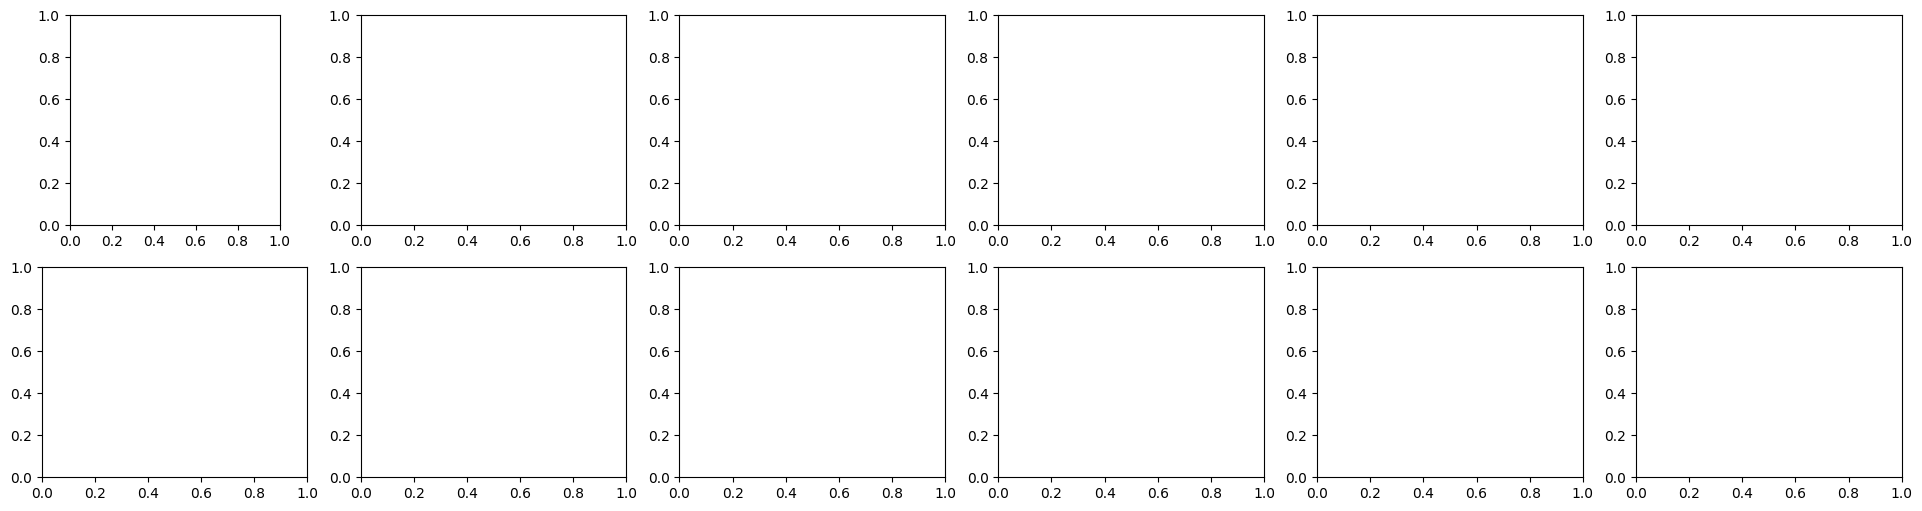

In [8]:
plot_images(images)